# Code from here https://spark-in.me/post/unet-adventures-part-one-getting-acquainted-with-unet

# another simple example https://www.kaggle.com/toregil/a-lung-u-net-in-keras/code

In [1]:
import numpy as np
import os
import smtplib
from keras.applications.resnet50 import ResNet50
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate, Conv3DTranspose, Concatenate
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Input, BatchNormalization, Lambda, UpSampling3D
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os

os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

def notify_me(msg):
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    with open('/home/tkyono/.emailsettings') as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    server.login(content[0], content[1])
    server.sendmail('DeepLearningBox', '8084460540@vtext.com', msg)

Using TensorFlow backend.


In [2]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return dice_coef(y_true, y_pred)




In [3]:
def read_hdf5(path, num_images):
    import h5py
    import pylab
    print(path)
    fh = h5py.File(path, 'r')

def show_img(img):
    pylab.imshow(img)
    pylab.colorbar()
    pylab.show()
    
def show_img_zoom(img):
    pylab.imshow(img)
    pylab.axis([1000,2000,1500,2500])
    pylab.colorbar()
    pylab.show()
    
    
import h5py
import pylab  



In [ ]:
model = get_unet()
#model = get_shared_unet()
#model = get_shared_autoencoder()
plot_model(model, to_file='unet1.png', show_shapes=True)

def normalize(A):
    return A
    #return np.nan_to_num((A - np.min(A)) / (np.max(A) - np.min(A)))
def standardize(A): 
    return (A - np.mean(A)) / np.std(A)


train_dir = '/home/tkyono/Desktop/bispectrum_training/*.h5'
val_dir = '/home/tkyono/Desktop/bispectrum_training/validate/*.h5'
batch_size = 16
num_files = 0
for i in glob.glob(train_dir):
    num_files += 1
#print("Found ", num_files, "files")
def generate(d):
    while True:
        #print("Recycling through files")
        for i in glob.glob(d):
            #print("Opening new file", i)
            hdf5 = h5py.File(i, 'r')
            num_images = len(hdf5['Degraded_imaginary']) // 16
            for j in range(num_images):
                Xr = []
                Yr = []
                Xi = []
                Yi = []
                j = batch_size * j
                F1Xi = hdf5['Degraded_imaginary'][j:j + batch_size]
                F1Xr = hdf5['Degraded_real'][j:j + batch_size]
                F1Yi = hdf5['Pristine_imaginary'][j:j + batch_size]
                F1Yr = hdf5['Pristine_real'][j:j + batch_size]
                F1Xr = np.moveaxis(F1Xr, 1, 4)
                for i in range(len(F1Xr)):
                    Xr.append(normalize(F1Xr[i])) 
                F1Yr = np.moveaxis(F1Yr, 1, 4)
                for i in range(len(F1Yr)):
                    Yr.append(normalize(F1Yr[i]))
                F1Xi = np.moveaxis(F1Xi, 1, 4)
                for i in range(len(F1Xi)):
                    Xi.append(normalize(F1Xi[i]))
                F1Yi = np.moveaxis(F1Yi, 1, 4)
                for i in range(len(F1Yi)):
                    Yi.append(normalize(F1Yi[i]))
                Xr = np.array(Xr)    
                Yr = np.array(Yr)    
                Xi = np.array(Xi)    
                Yi = np.array(Yi)  
                #yield [Xi, Xr], [Yi, Yr]
                yield Xi, Yi
            hdf5.close()
            
callbacks = [ModelCheckpoint('best_save1', verbose=1, monitor='val_loss',save_best_only=True),
            EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=6, verbose=1, mode='auto')
           ]

#model.compile(optimizer=optimizers.Adam(lr = 1e-4),metrics = ['mean_squared_error', 'mean_squared_error'],
#              loss = ['mean_squared_error', 'mean_squared_error'])  
model.compile(optimizer=optimizers.Adam(lr = 1e-4),metrics = ['mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 10, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1600 // batch_size)

In [ ]:
callbacks = [ModelCheckpoint('best_imaginary2', verbose=1, monitor='val_loss',save_best_only=True),
            EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=6, verbose=1, mode='auto')
           ]
model.compile(optimizer=optimizers.Adam(lr = 1e-5),metrics = [ 'mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 10, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)

In [ ]:
model = load_model('best_imaginary2')

In [ ]:
test_dir = '/home/tkyono/Desktop/bispectrum_training/test/bispec_val_20180730.mat_ensemble_1_of_1.mat.h5'
#batch_size = 10

#files = [f1]

Xr = []
Xi = []
Yr = []
Yi = []
F1 = h5py.File(test_dir, 'r')
F1Xi = F1['Degraded_imaginary']
F1Xr = F1['Degraded_real']
F1Yi = F1['Pristine_imaginary']
F1Yr = F1['Pristine_real']
F1Xr = np.moveaxis(F1Xr, 1, 4)
for i in range(len(F1Xr)):
    Xr.append(normalize(F1Xr[i])) 
F1Yr = np.moveaxis(F1Yr, 1, 4)
for i in range(len(F1Yr)):
    Yr.append(normalize(F1Yr[i]))
F1Xi = np.moveaxis(F1Xi, 1, 4)
for i in range(len(F1Xi)):
    Xi.append(normalize(F1Xi[i]))
F1Yi = np.moveaxis(F1Yi, 1, 4)
for i in range(len(F1Yi)):
    Yi.append(normalize(F1Yi[i]))
        
F1Xr = []
F1Yr = []
F1Xi = []
F1Yi = []
Xr = np.array(Xr)    
Yr = np.array(Yr)    
Xi = np.array(Xi)    
Yi = np.array(Yi)    
#model.fit( x = np.nan_to_num(Xr), y =np.nan_to_num(Yr), batch_size = 16, validation_split=0.2, epochs = 100)

In [ ]:
Ypred = model.predict(Xi)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print("Predicted")
plt.imshow(Ypred[3,3,:,:,1])
plt.show()

print("Noisy")
plt.imshow(Xi[3,3,:,:,1])
plt.show()

print("Pristine")
plt.imshow(Yi[3,3,:,:,1])
plt.show()

In [ ]:
len(Ypred[0]), len(Xr), np.min(Ypred[0]), np.max(Ypred[0]), np.min(Ypred[1]), np.max(Ypred[1])

In [ ]:
hf = h5py.File('predicted_imaginary.h5', 'w')
hf.create_dataset('imaginary', data = Ypred)
hf.close()

In [ ]:

def get_unet():

    inputs = Input((5, 64, 64, 5))
    #bn = BatchNormalization()(inputs)
    conv1 = Conv3D(32, (1, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (1, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv3D(512, (1, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (1, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(256, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(32, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (1, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (1, 3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv3D(5, (1, 1, 1), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model


'''
def get_unet():

    inputs = Input((5, 64, 64, 5))
    #bn = BatchNormalization()(inputs)
    conv1 = Conv3D(64, (1, 3, 3), activation='tanh', padding='same')(inputs)
    conv1 = Conv3D(64, (1, 3, 3), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)
    #pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv3D(64, (1, 3, 3), activation='tanh', padding='same')(pool1)
    conv2 = Conv3D(64, (1, 3, 3), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)
    #pool2 = BatchNormalization()(pool2)

    conv3 = Conv3D(128, (1, 3, 3), activation='tanh', padding='same')(pool2)
    conv3 = Conv3D(128, (1, 3, 3), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)
    #pool3 = BatchNormalization()(pool3)

    conv4 = Conv3D(256, (1, 3, 3), activation='tanh', padding='same')(pool3)
    conv4 = Conv3D(256, (1, 3, 3), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)
    #pool4 = BatchNormalization()(pool4)

    conv5 = Conv3D(512, (1, 3, 3), activation='tanh', padding='same')(pool4)
    conv5 = Conv3D(512, (1, 3, 3), activation='tanh', padding='same')(conv5)
    #conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(256, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(256, (1, 3, 3), activation='tanh', padding='same')(up6)
    conv6 = Conv3D(256, (1, 3, 3), activation='tanh', padding='same')(conv6)
    #conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(128, (1, 3, 3), activation='tanh', padding='same')(up7)
    conv7 = Conv3D(128, (1, 3, 3), activation='tanh', padding='same')(conv7)
    #conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(64, (1, 3, 3), activation='tanh', padding='same')(up8)
    conv8 = Conv3D(64, (1, 3, 3), activation='tanh', padding='same')(conv8)
    #conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(32, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(64, (1, 3, 3), activation='tanh', padding='same')(up9)
    conv9 = Conv3D(64, (1, 3, 3), activation='tanh', padding='same')(conv9)
    #conv9 = BatchNormalization()(conv9)
    conv10 = Conv3D(5, (1, 1, 1), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model


'''


def get_unet2():

    inputs = Input((5, 64, 64, 5))
    bn = BatchNormalization()(inputs)
    conv1 = Conv3D(32, (1, 3, 3), activation='relu', padding='same')(bn)
    conv1 = Conv3D(32, (1, 3, 3), strides = (1, 2, 2), activation='relu', padding='same')(conv1)
    
    pool1 = BatchNormalization()(conv1)
    
    conv2 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (1, 3, 3), strides = (1, 2, 2), activation='relu', padding='same')(conv2)

    pool2 = BatchNormalization()(conv2)

    conv3 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (1, 3, 3), strides = (1, 2, 2),activation='relu', padding='same')(conv3)

    pool3 = BatchNormalization()(conv3)

    conv4 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (1, 3, 3), strides = (1, 2, 2),activation='relu', padding='same')(conv4)

    pool4 = BatchNormalization()(conv4)

    conv5 = Conv3D(512, (1, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (1, 3, 3), strides = (1, 2, 2), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(256, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(32, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (1, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (1, 3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv3DTranspose(5, (1, 1, 1), strides = (1,2,2), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model

def get_shared_unet():
    IMAG = Input((5, 64, 64, 5))
    REAL = Input((5, 64, 64, 5))
    bn = BatchNormalization()
    i = bn(IMAG); r = bn(REAL)
    
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i = conv1(i); r = conv1(r)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i5 = conv1(i); r5 = conv1(r)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))
    i = pool1(i5); r = pool1(r5)
    pool1 = BatchNormalization()
    i = pool1(i); r = pool1(r)
    
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')
    i = conv2(i); r = conv2(r)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')
    i = conv2(i); r = conv2(r)
    conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i4 = conv2(i); r4 = conv2(r)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))
    i = pool2(i4); r = pool2(r4)
    pool2 = BatchNormalization()
    i = pool2(i); r = pool2(r)
    
    
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')
    i = conv3(i); r = conv3(r)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')
    i3 = conv3(i); r3 = conv3(r)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))
    i = pool3(i3); r = pool3(r3)
    pool3 = BatchNormalization()
    i = pool3(i); r = pool3(r)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')
    i = conv4(i); r = conv4(r)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')
    i2 = conv4(i); r2 = conv4(r)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))
    i = pool4(i2); r = pool4(r2)
    pool4 = BatchNormalization()
    i = pool4(i); r = pool4(r)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')
    i = conv5(i); r = conv5(r)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')
    i = conv5(i); r = conv5(r)
    conv5 = BatchNormalization()
    i = conv5(i); r = conv5(r)

    conv5 = Conv3DTranspose(256, (1, 2, 2), strides=(1, 2, 2), padding='same')
    i = conv5(i); r = conv5(r)
    cat = Concatenate(axis=4)
    i = cat([i, i2]); r = cat([r, r2])
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')
    i = conv6(i); r = conv6(r) 
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')
    i = conv6(i); r = conv6(r)
    conv6 = BatchNormalization()
    i = conv6(i); r = conv6(r)
    
    conv6 = Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')
    i = conv6(i); r = conv6(r)
    cat = Concatenate(axis=4)
    i = cat([i, i3]); r = cat([r, r3])
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')
    i = conv7(i); r = conv7(r)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')
    i = conv7(i); r = conv7(r)
    conv7 = BatchNormalization()
    i = conv7(i); r = conv7(r)
    
    conv7 = Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')
    i = conv7(i); r = conv7(r)
    cat = Concatenate(axis=4)
    i = cat([i, i4]); r = cat([r, r4])
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')
    i = conv8(i); r = conv8(r)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')
    i = conv8(i); r = conv8(r)
    conv8 = BatchNormalization()
    i = conv8(i); r = conv8(r)
                       
    conv8 = Conv3DTranspose(32, (1, 2, 2), strides=(1, 2, 2), padding='same')
    i = conv8(i); r = conv8(r)                   
    cat = Concatenate(axis=4)
    i = cat([i, i5]); r = cat([r, r5])
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i = conv9(i); r = conv9(r)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i = conv9(i); r = conv9(r)
    conv9 = BatchNormalization()
    i = conv9(i); r = conv9(r)
    conv10 = Conv3D(5, (1, 1, 1), activation='sigmoid')
    #conv10 = Conv3D(5, (1, 1, 1), activation='linear')
    i = conv10(i); r = conv10(r)

    model = Model(inputs=[IMAG, REAL], outputs=[i, r])
    
    return model


def get_shared_autoencoder():
    IMAG = Input((5, 64, 64, 5))
    REAL = Input((5, 64, 64, 5))
    bn = BatchNormalization()
    i = bn(IMAG); r = bn(REAL)
    
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i = conv1(i); r = conv1(r)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i5 = conv1(i); r5 = conv1(r)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))
    i = pool1(i5); r = pool1(r5)
    pool1 = BatchNormalization()
    i = pool1(i); r = pool1(r)
    
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')
    i = conv2(i); r = conv2(r)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')
    i = conv2(i); r = conv2(r)
    conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i4 = conv2(i); r4 = conv2(r)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))
    i = pool2(i4); r = pool2(r4)
    pool2 = BatchNormalization()
    i = pool2(i); r = pool2(r)
    
    
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')
    i = conv3(i); r = conv3(r)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')
    i3 = conv3(i); r3 = conv3(r)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))
    i = pool3(i3); r = pool3(r3)
    pool3 = BatchNormalization()
    i = pool3(i); r = pool3(r)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')
    i = conv4(i); r = conv4(r)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')
    i2 = conv4(i); r2 = conv4(r)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))
    i = pool4(i2); r = pool4(r2)
    pool4 = BatchNormalization()
    i = pool4(i); r = pool4(r)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')
    i = conv5(i); r = conv5(r)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')
    i = conv5(i); r = conv5(r)
    conv5 = BatchNormalization()
    i = conv5(i); r = conv5(r)

    conv5 = Conv3DTranspose(256, (1, 2, 2), strides=(1, 2, 2), padding='same')
    i = conv5(i); r = conv5(r)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')
    i = conv6(i); r = conv6(r) 
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')
    i = conv6(i); r = conv6(r)
    conv6 = BatchNormalization()
    i = conv6(i); r = conv6(r)
    
    conv6 = Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')
    i = conv6(i); r = conv6(r)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')
    i = conv7(i); r = conv7(r)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')
    i = conv7(i); r = conv7(r)
    conv7 = BatchNormalization()
    i = conv7(i); r = conv7(r)
    
    conv7 = Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')
    i = conv7(i); r = conv7(r)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')
    i = conv8(i); r = conv8(r)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')
    i = conv8(i); r = conv8(r)
    conv8 = BatchNormalization()
    i = conv8(i); r = conv8(r)
                       
    conv8 = Conv3DTranspose(32, (1, 2, 2), strides=(1, 2, 2), padding='same')
    i = conv8(i); r = conv8(r)                   

    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i = conv9(i); r = conv9(r)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')
    i = conv9(i); r = conv9(r)
    conv9 = BatchNormalization()
    i = conv9(i); r = conv9(r)
    conv10 = Conv3D(5, (1, 1, 1), activation='sigmoid')
    #conv10 = Conv3D(5, (1, 1, 1), activation='linear')
    i = conv10(i); r = conv10(r)

    model = Model(inputs=[IMAG, REAL], outputs=[i, r])
    
    return model

# Do REAL

In [6]:
#tanh was pretty close....
def get_unet():

    inputs = Input((5, 64, 64, 5))
    #bn = BatchNormalization()(inputs)
    conv1 = Conv3D(64, (2, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(64, (2, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv3D(128, (2, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(128, (2, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv3D(1024, (2, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(1024, (2, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(512, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(128, (2, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(128, (2, 3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(32, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(64, (2, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(64, (2, 3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv3D(5, (1, 1, 1), activation='tanh')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model


model = get_unet()
plot_model(model, to_file='unet1.png', show_shapes=True)

def normalize(A):
    return A
    #return (A - np.min(A)) / (np.max(A) - np.min(A))
def standardize(A): 
    return normalize((A - np.mean(A)) / np.std(A))


train_dir = '/home/tkyono/Desktop/bispectrum_training/*.h5'
val_dir = '/home/tkyono/Desktop/bispectrum_training/validate/*.h5'
batch_size = 16
num_files = 0
for i in glob.glob(train_dir):
    num_files += 1
#print("Found ", num_files, "files")
def generate(d):
    while True:
        #print("Recycling through files")
        for i in glob.glob(d):
            #print("Opening new file", i)
            hdf5 = h5py.File(i, 'r')
            num_images = len(hdf5['Degraded_imaginary']) // 16
            for j in range(num_images):
                Xr = []
                Yr = []
                Xi = []
                Yi = []
                j = batch_size * j
                F1Xi = hdf5['Degraded_imaginary'][j:j + batch_size]
                F1Xr = hdf5['Degraded_real'][j:j + batch_size]
                F1Yi = hdf5['Pristine_imaginary'][j:j + batch_size]
                F1Yr = hdf5['Pristine_real'][j:j + batch_size]
                F1Xr = np.moveaxis(F1Xr, 1, 4)
                for i in range(len(F1Xr)):
                    Xr.append(normalize(F1Xr[i])) 
                F1Yr = np.moveaxis(F1Yr, 1, 4)
                for i in range(len(F1Yr)):
                    Yr.append(normalize(F1Yr[i]))
                F1Xi = np.moveaxis(F1Xi, 1, 4)
                for i in range(len(F1Xi)):
                    Xi.append(normalize(F1Xi[i]))
                F1Yi = np.moveaxis(F1Yi, 1, 4)
                for i in range(len(F1Yi)):
                    Yi.append(normalize(F1Yi[i]))
                Xr = np.array(Xr)    
                Yr = np.array(Yr)    
                Xi = np.array(Xi)    
                Yi = np.array(Yi)  
                yield Xr, Yr
            hdf5.close()
            
callbacks = [ModelCheckpoint('best_real', verbose=1, monitor='val_mean_squared_error',save_best_only=True),
            EarlyStopping(monitor='val_mean_squared_error', min_delta=0.00001, patience=10, verbose=1, mode='auto')
           ]

model.compile(optimizer=optimizers.Adam(lr = 1e-3),metrics = ['mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)
            

model = load_model('best_real')
callbacks = [ModelCheckpoint('best_real', verbose=1, monitor='val_mean_squared_error',save_best_only=True),
            EarlyStopping(monitor='val_mean_squared_error', min_delta=0.00001, patience=10, verbose=1, mode='auto')
           ]
model.compile(optimizer=optimizers.Adam(lr = 1e-4),metrics = ['mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)


model = load_model('best_real')
callbacks = [ModelCheckpoint('best_real', verbose=1, monitor='val_mean_squared_error',save_best_only=True),
            EarlyStopping(monitor='val_mean_squared_error', min_delta=0.00001, patience=10, verbose=1, mode='auto')
           ]
model.compile(optimizer=optimizers.Adam(lr = 1e-5),metrics = [ 'mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)
  




Epoch 1/100
625/625 [==============================] - 320s 512ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0405 - val_mean_squared_error: 0.0405

Epoch 00001: val_mean_squared_error improved from inf to 0.04051, saving model to best_real
Epoch 2/100
625/625 [==============================] - 319s 510ms/step - loss: 9.5337e-05 - mean_squared_error: 9.5337e-05 - val_loss: 0.0313 - val_mean_squared_error: 0.0313

Epoch 00002: val_mean_squared_error improved from 0.04051 to 0.03127, saving model to best_real
Epoch 3/100
625/625 [==============================] - 318s 510ms/step - loss: 7.3870e-05 - mean_squared_error: 7.3870e-05 - val_loss: 0.0251 - val_mean_squared_error: 0.0251

Epoch 00003: val_mean_squared_error improved from 0.03127 to 0.02512, saving model to best_real
Epoch 4/100
625/625 [==============================] - 320s 512ms/step - loss: 6.3591e-05 - mean_squared_error: 6.3591e-05 - val_loss: 0.0070 - val_mean_squared_error: 0.0070

Epoch 00004: val_mea

625/625 [==============================] - 320s 512ms/step - loss: 2.9142e-05 - mean_squared_error: 2.9142e-05 - val_loss: 4.1199e-04 - val_mean_squared_error: 4.1199e-04

Epoch 00006: val_mean_squared_error did not improve
Epoch 7/100
625/625 [==============================] - 320s 512ms/step - loss: 2.8560e-05 - mean_squared_error: 2.8560e-05 - val_loss: 4.2191e-04 - val_mean_squared_error: 4.2191e-04

Epoch 00007: val_mean_squared_error did not improve
Epoch 8/100
625/625 [==============================] - 320s 512ms/step - loss: 2.8056e-05 - mean_squared_error: 2.8056e-05 - val_loss: 4.4527e-04 - val_mean_squared_error: 4.4527e-04

Epoch 00008: val_mean_squared_error did not improve
Epoch 9/100
625/625 [==============================] - 320s 512ms/step - loss: 2.7687e-05 - mean_squared_error: 2.7687e-05 - val_loss: 4.3327e-04 - val_mean_squared_error: 4.3327e-04

Epoch 00009: val_mean_squared_error did not improve
Epoch 10/100
625/625 [==============================] - 321s 513ms/s

1.0
Predicted


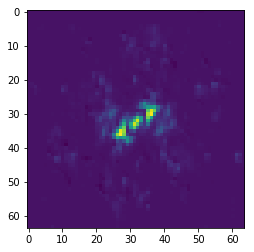

-0.02539188 0.47931573
Noisy


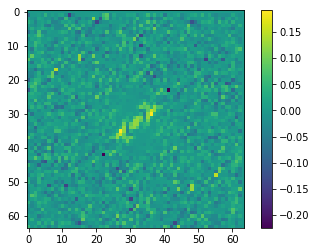

-0.2243788597109258 0.19109654795424208
Pristine


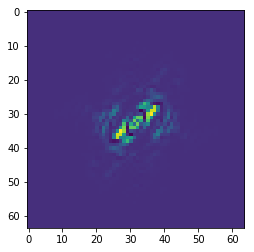

-0.06600425168093851 0.4196257379491521
Predicted


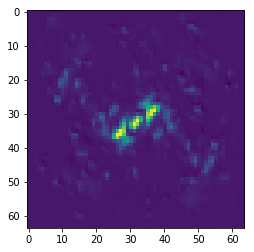

-0.0348571 0.519389
Noisy


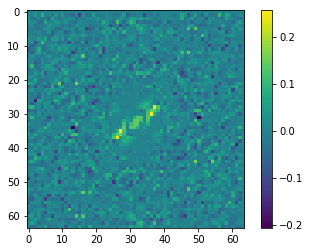

-0.2062706593453905 0.2558484195086589
Pristine


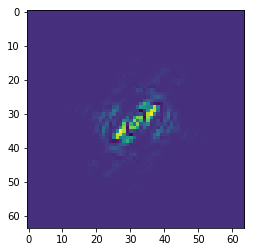

-0.06397034068941714 0.39838140005115236
Predicted


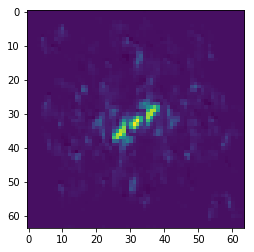

-0.022240138 0.49709803
Noisy


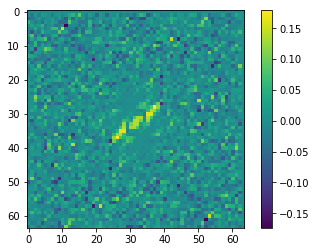

-0.1735264232567569 0.17903457829672198
Pristine


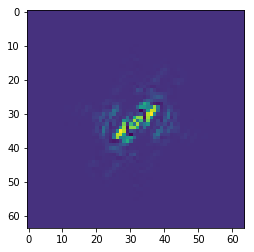

-0.062201179394055256 0.3787231721873634
Predicted


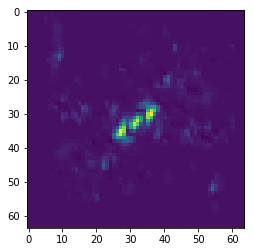

-0.02381022 0.51998246
Noisy


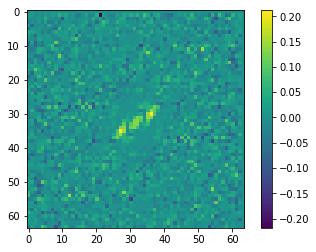

-0.2183132894979087 0.21180402433251783
Pristine


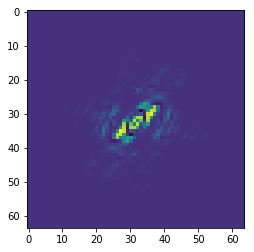

-0.0602852227783964 0.3574593330219262
Predicted


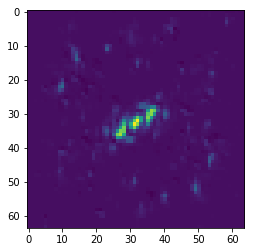

-0.018935174 0.48573714
Noisy


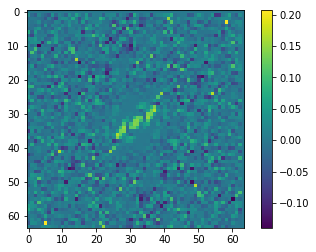

-0.1396483769405049 0.20672883888589302
Pristine


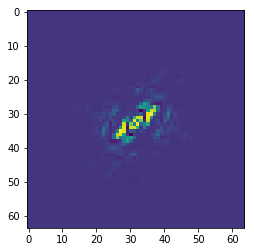

-0.05859413457879225 0.33376253254785865


In [7]:
def normalize(A):
    return A
    #return (A - np.min(A)) / (np.max(A) - np.min(A))
def standardize(A): 
    return normalize((A - np.mean(A)) / np.std(A))

model = load_model('best_real')
test_dir = '/home/tkyono/Desktop/bispectrum_training/validate/bispec_training_validation_20180806.mat_ensemble_1_of_1_scaled_stdev.mat.h5'

Xr = []
Xi = []
Yr = []
Yi = []
F1 = h5py.File(test_dir, 'r')
F1Xi = F1['Degraded_imaginary']
F1Xr = F1['Degraded_real']
F1Yi = F1['Pristine_imaginary']
F1Yr = F1['Pristine_real']
F1Xr = np.moveaxis(F1Xr, 1, 4)
for i in range(len(F1Xr)):
    Xr.append(normalize(F1Xr[i])) 
F1Yr = np.moveaxis(F1Yr, 1, 4)
for i in range(len(F1Yr)):
    Yr.append(normalize(F1Yr[i]))
F1Xi = np.moveaxis(F1Xi, 1, 4)
for i in range(len(F1Xi)):
    Xi.append(normalize(F1Xi[i]))
F1Yi = np.moveaxis(F1Yi, 1, 4)
for i in range(len(F1Yi)):
    Yi.append(normalize(F1Yi[i]))
        
F1Xr = []
F1Yr = []
F1Xi = []
F1Yi = []
Xr = np.array(Xr)    
Yr = np.array(Yr)    
Xi = np.array(Xi)    
Yi = np.array(Yi) 


import matplotlib.pyplot as plt


Ypred = model.predict(Xr)
print(np.max(Ypred))
for i in range(5):
    print("Predicted")
    plt.imshow(Ypred[i,3,:,:,1])
    plt.show()
    print(np.min(Ypred[i,3,:,:,1]),np.max(Ypred[i,3,:,:,1]))
    
    #print("Predicted - Noisy")
    #plt.imshow(Ypred[i,3,:,:,1] - Xr[i,3,:,:,1])
    #plt.show()

    #print("Predicted - Pristine")
    #plt.imshow(Ypred[i,3,:,:,1] - Yr[i,3,:,:,1])
    #plt.show()


    print("Noisy")
    plt.imshow(Xr[i,3,:,:,1])
    plt.colorbar()
    plt.show()
    print(np.min(Xr[i,3,:,:,1]),np.max(Xr[i,3,:,:,1]))
    print("Pristine")
    plt.imshow(Yr[i,3,:,:,1])
    plt.show()
    print(np.min(Yr[i,3,:,:,1]),np.max(Yr[i,3,:,:,1]))

In [ ]:


hf = h5py.File('predicted_real.h5', 'w')
hf.create_dataset('real', data = Ypred)
hf.close()

In [ ]:
np.max(Xr[0]), np.min(Xr[0])

# Do Imaginary

In [ ]:

model = get_unet()
plot_model(model, to_file='unet1.png', show_shapes=True)

def normalize(A):
    return A
    #return (A - np.min(A)) / (np.max(A) - np.min(A))
def standardize(A): 
    return normalize((A - np.mean(A)) / np.std(A))


train_dir = '/home/tkyono/Desktop/bispectrum_training/*.h5'
val_dir = '/home/tkyono/Desktop/bispectrum_training/validate/*.h5'
batch_size = 16
num_files = 0
for i in glob.glob(train_dir):
    num_files += 1
#print("Found ", num_files, "files")
def generate(d):
    while True:
        #print("Recycling through files")
        for i in glob.glob(d):
            #print("Opening new file", i)
            hdf5 = h5py.File(i, 'r')
            num_images = len(hdf5['Degraded_imaginary']) // 16
            for j in range(num_images):
                Xr = []
                Yr = []
                Xi = []
                Yi = []
                j = batch_size * j
                F1Xi = hdf5['Degraded_imaginary'][j:j + batch_size]
                F1Xr = hdf5['Degraded_real'][j:j + batch_size]
                F1Yi = hdf5['Pristine_imaginary'][j:j + batch_size]
                F1Yr = hdf5['Pristine_real'][j:j + batch_size]
                F1Xr = np.moveaxis(F1Xr, 1, 4)
                for i in range(len(F1Xr)):
                    Xr.append(normalize(F1Xr[i])) 
                F1Yr = np.moveaxis(F1Yr, 1, 4)
                for i in range(len(F1Yr)):
                    Yr.append(normalize(F1Yr[i]))
                F1Xi = np.moveaxis(F1Xi, 1, 4)
                for i in range(len(F1Xi)):
                    Xi.append(normalize(F1Xi[i]))
                F1Yi = np.moveaxis(F1Yi, 1, 4)
                for i in range(len(F1Yi)):
                    Yi.append(normalize(F1Yi[i]))
                Xr = np.array(Xr)    
                Yr = np.array(Yr)    
                Xi = np.array(Xi)    
                Yi = np.array(Yi)  
                yield Xi, Yi
            hdf5.close()

callbacks = [ModelCheckpoint('best_imaginary', verbose=1, monitor='val_mean_squared_error',save_best_only=True),
            EarlyStopping(monitor='val_mean_squared_error', min_delta=0.00001, patience=10, verbose=1, mode='auto')
           ]

model.compile(optimizer=optimizers.Adam(lr = 1e-3),metrics = ['mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)
            

model = load_model('best_imaginary')
model.compile(optimizer=optimizers.Adam(lr = 1e-4),metrics = ['mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)


model = load_model('best_imaginary')
model.compile(optimizer=optimizers.Adam(lr = 1e-5),metrics = [ 'mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)
  

In [ ]:

model = load_model('best_imaginary')
test_dir = '/home/tkyono/Desktop/bispectrum_training/validate/bispec_training_validation_20180806.mat_ensemble_1_of_1_scaled_stdev.mat.h5'

Xr = []
Xi = []
Yr = []
Yi = []
F1 = h5py.File(test_dir, 'r')
F1Xi = F1['Degraded_imaginary']
F1Xr = F1['Degraded_real']
F1Yi = F1['Pristine_imaginary']
F1Yr = F1['Pristine_real']
F1Xr = np.moveaxis(F1Xr, 1, 4)
for i in range(len(F1Xr)):
    Xr.append(normalize(F1Xr[i])) 
F1Yr = np.moveaxis(F1Yr, 1, 4)
for i in range(len(F1Yr)):
    Yr.append(normalize(F1Yr[i]))
F1Xi = np.moveaxis(F1Xi, 1, 4)
for i in range(len(F1Xi)):
    Xi.append(normalize(F1Xi[i]))
F1Yi = np.moveaxis(F1Yi, 1, 4)
for i in range(len(F1Yi)):
    Yi.append(normalize(F1Yi[i]))
        
F1Xr = []
F1Yr = []
F1Xi = []
F1Yi = []
Xr = np.array(Xr)    
Yr = np.array(Yr)    
Xi = np.array(Xi)    
Yi = np.array(Yi) 

import matplotlib.pyplot as plt


Ypred = model.predict(Xi)
for i in range(5):
    print("Predicted")
    plt.imshow(Ypred[i,3,:,:,1])
    plt.show()
    print(np.min(Ypred[i,3,:,:,1]),np.max(Ypred[i,3,:,:,1]))
    
    #print("Predicted - Noisy")
    #plt.imshow(Ypred[i,3,:,:,1] - Xr[i,3,:,:,1])
    #plt.show()

    #print("Predicted - Pristine")
    #plt.imshow(Ypred[i,3,:,:,1] - Yr[i,3,:,:,1])
    #plt.show()


    print("Noisy")
    plt.imshow(Xi[i,3,:,:,1])
    plt.colorbar()
    plt.show()
    print(np.min(Xi[i,3,:,:,1]),np.max(Xi[i,3,:,:,1]))
    print("Pristine")
    plt.imshow(Yi[i,3,:,:,1])
    plt.show()
    print(np.min(Yi[i,3,:,:,1]),np.max(Yi[i,3,:,:,1]))

hf = h5py.File('predicted_imaginary.h5', 'w')
hf.create_dataset('imaginary', data = Ypred)
hf.close()

In [ ]:
Xr = []
Xi = []
Yr = []
Yi = []
F1 = h5py.File(test_dir, 'r')
F1Xi = F1['Degraded_imaginary']
F1Xr = F1['Degraded_real']
F1Yi = F1['Pristine_imaginary']
F1Yr = F1['Pristine_real']
F1Xr = np.moveaxis(F1Xr, 1, 4)
for i in range(len(F1Xr)):
    Xr.append(normalize(F1Xr[i])) 
F1Yr = np.moveaxis(F1Yr, 1, 4)
for i in range(len(F1Yr)):
    Yr.append(normalize(F1Yr[i]))
F1Xi = np.moveaxis(F1Xi, 1, 4)
for i in range(len(F1Xi)):
    Xi.append(normalize(F1Xi[i]))
F1Yi = np.moveaxis(F1Yi, 1, 4)
for i in range(len(F1Yi)):
    Yi.append(normalize(F1Yi[i]))

Xr = np.array(Xr)    
Yr = np.array(Yr)    
Xi = np.array(Xi)    
Yi = np.array(Yi)   

print(len(F1Xi), len(F1Yi), len(F1Xr), len(F1Yr))

model = load_model('best_imaginary')
IMAG = model.predict(Xi)
plt.imshow(IMAG[0,3,:,:,1])
plt.show()
    

model = load_model('best_real')
REAL = model.predict(Xr)
plt.imshow(REAL[0,3,:,:,1])
plt.show() 
hf = h5py.File('predicted_both.h5', 'w')
hf.create_dataset('imaginary', data = IMAG)
hf.create_dataset('real', data = REAL)
hf.close()

In [ ]:
np.min(REAL[1,3,:,:,4]), np.max(REAL[1,3,:,:,4])